In [2]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [3]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-8, 1e-8],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.5,
    'bisection_tol': 1e-12,
}

In [4]:
def integrate_one_cycle(sim, configs):
    time_step = configs['init_time_step']
    bisection_tol = configs['bisection_tol']
    target_mean_anomaly = configs['target_mean_anomaly']
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_sin_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_sin_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on sin M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < 1e-8:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [5]:
def init_simulation(theta, configs):
    inner_period = configs['inner_period']
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=configs['planet_mass'][0], P=inner_period, e=init_e[0])
    sim.add(m=configs['planet_mass'][1], P=inner_period*configs['kappa'], pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta, configs):
    init_theta = theta
    init_sim = init_simulation(init_theta, configs)

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim, configs)
    final_sim.move_to_hel()
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    # print(init_theta, final_theta)
    # print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    # print(diff)
    return diff

    # return theta_diff

[-5.89885767e+00 -8.77307847e+00 -8.71069855e-03 -8.17752127e-03] 4.900780991176448e-06
[-3.51236105e+00 -7.77088628e+00 -7.43342220e-03 -1.16444988e-02] 4.934342043669755e-06
[-2.60970405 -6.78223774 -0.00898673 -0.01415134] 4.9399324761311355e-06
[-1.72273162 -5.88555613 -0.01407657 -0.01517789] 4.940420851420245e-06
[-1.2128665  -5.26892251 -0.0168188  -0.01845568] 4.9411251955195235e-06
[-1.06625208 -4.78039419 -0.02021772 -0.01629397] 4.945587309710085e-06
[-1.01994334 -4.49040165 -0.02025106 -0.01800105] 4.984631784761622e-06
[-1.01008652 -4.47668214 -0.02029345 -0.01862743] 5.367709141471486e-06
[-1.00676839 -4.22047352 -0.02137732 -0.01916079] 9.89711542635469e-06
[-1.00676839 -4.22047352 -0.02137732 -0.01916079]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.999), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


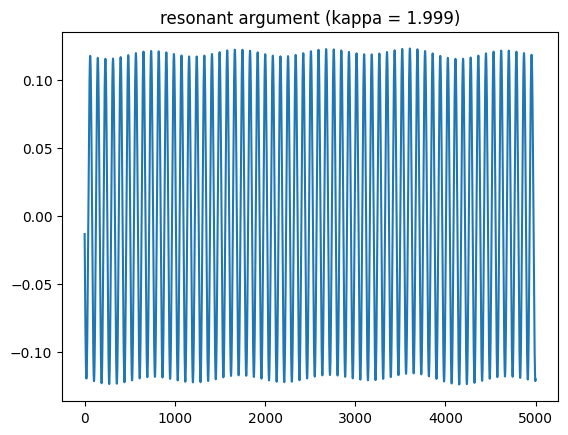

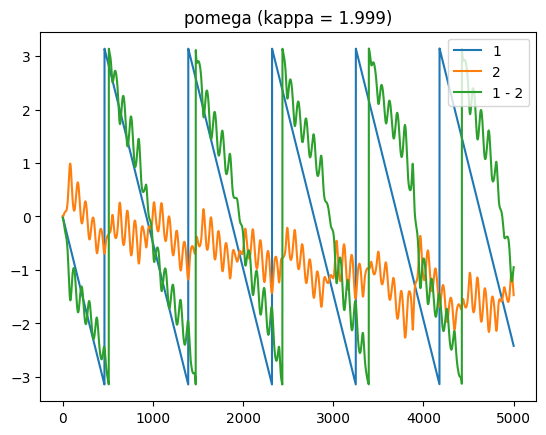

[-4.82619462e+00 -8.67065130e+00 -1.83035145e-02 -5.36417703e-03] 3.150225845214166e-06
[-4.55961595e+00 -7.66824737e+00 -2.12467889e-02 -5.66604803e-03] 3.1646339596702777e-06
[-2.23704978 -6.70487304 -0.02886223 -0.00744326] 3.161563013968498e-06
[-2.29383883 -5.7011661  -0.03205297 -0.00769775] 3.1637861670388572e-06
[-1.25237825 -5.09320932 -0.08321101 -0.00729649] 3.161966130495079e-06
[-1.20855063 -4.15423824 -0.09052838 -0.00781394] 3.171395021191567e-06
[-1.0129822  -4.7954603  -0.02133216 -0.01987766] 3.195118413061371e-06
[-1.00901866 -4.65096829 -0.02178312 -0.02044711] 3.5031741264182663e-06
[-0.80003618 -0.93407592 -1.54250206 -1.92500623] 9.593276074326667e-07
[-0.80003618 -0.93407592 -1.54250206 -1.92500623]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9992), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


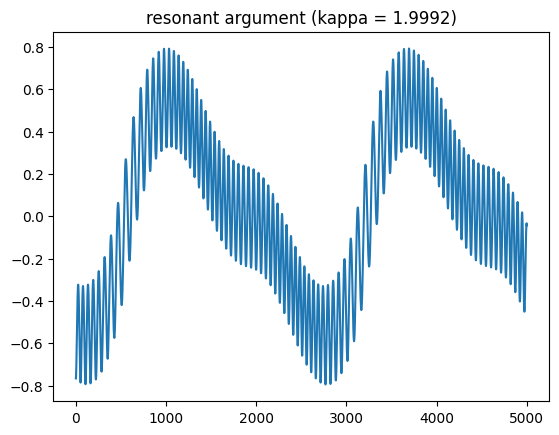

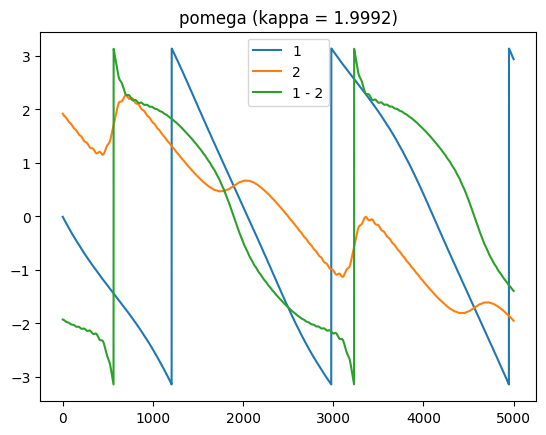

[-6.22933723e+00 -8.54233759e+00 -1.52062728e-02 -7.06477737e-03] 1.784019470653191e-06
[-3.21653611e+00 -7.54774699e+00 -1.34561955e-02 -7.12230341e-03] 1.7770101370545778e-06
[-3.20317317 -6.55044809 -0.01453454 -0.0075707 ] 1.7790008390130939e-06
[-1.61877503 -5.69639037 -0.02213588 -0.00680266] 1.7779981952587098e-06
[-1.24035188e+00 -4.99166619e+00 -4.82624551e-02 -1.95151837e-03] 1.7784339090042172e-06
[-1.17538574e+00 -4.10424846e+00 -5.41920412e-02 -2.19423014e-03] 1.7846272811413418e-06
[-1.01204774e+00 -4.67639365e+00 -4.29898264e-03 -3.35877283e-03] 1.8032198635674948e-06
[-0.80000381 -0.86576501  0.04506291 -0.0515316 ] 1.3499386104863062e-06
[-0.80001336 -1.70765406 -0.04495347 -0.07627622] 1.4864382024435612e-06
[-0.80001336 -1.70765406 -0.04495347 -0.07627622]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9994), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 

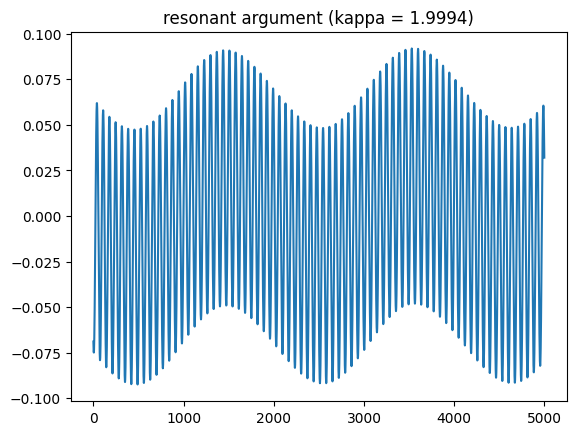

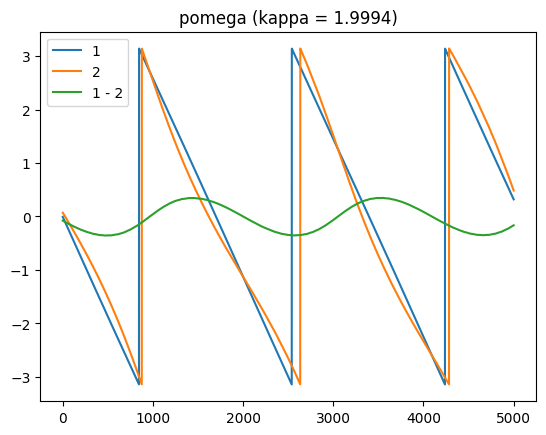

[-3.26200587e+00 -8.36911589e+00 -8.14813937e-03 -1.44779623e-03] 7.83592426500857e-07
[-3.33057220e+00 -7.37341846e+00 -8.46851104e-03 -1.50304098e-03] 7.893490925318886e-07
[-3.28025885e+00 -6.37173834e+00 -9.29398586e-03 -1.57933261e-03] 7.90955232498468e-07
[-1.48688788e+00 -5.58179317e+00 -2.58488490e-02 -1.26610159e-03] 7.900694312171268e-07
[-1.21046340e+00 -4.86625463e+00 -3.05011833e-02 -1.48801652e-03] 7.903848354022134e-07
[-1.13617159e+00 -4.03193825e+00 -3.43346038e-02 -1.51559207e-03] 7.937960571745685e-07
[-1.01081772e+00 -4.53029861e+00 -1.96512066e-03 -1.36630560e-03] 8.06898850265254e-07
[-0.8        -1.15316558  0.10076294 -0.08916027] 6.301852277141457e-07
[-0.8        -1.21164542 -1.42434891 -1.68506348] 3.083309749992568e-07
[-0.8        -1.21164542 -1.42434891 -1.68506348]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9996), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'i

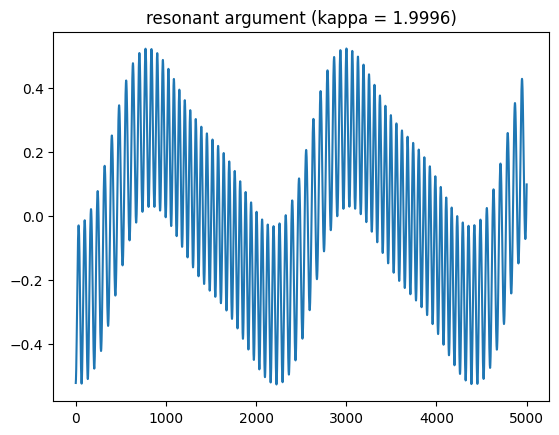

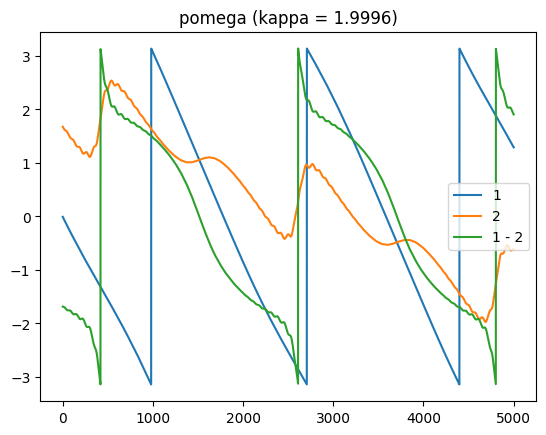

[-1.44474092e+00 -2.25073268e+00 -6.28416916e-04 -1.21287362e-03] 3.9460528808076164e-07
[-1.51718936e+00 -2.24997954e+00 -6.28206726e-04 -1.21295171e-03] 3.9464369018840325e-07
[-1.51718936e+00 -2.24997954e+00 -6.28206726e-04 -1.24327551e-03] 3.946436943475983e-07
[-1.79588225e+00 -5.15923823e+00 -1.02837436e-04  2.66364430e-03] 1.9753876647158502e-07
[-1.25633209e+00 -4.48823410e+00 -7.17902580e-05  4.28591362e-03] 1.977043871837935e-07
[-1.05231339e+00 -4.15806131e+00 -8.23735826e-05  4.82962392e-03] 1.9857813169041e-07
[-1.02035531e+00 -3.52759049e+00 -8.94036421e-05  4.93605931e-03] 2.0699483852524407e-07
[-0.80000056 -1.55153265 -0.0021437  -0.11820253] 1.6692808985070023e-07
[-0.8000008  -1.75110659 -0.00329481 -0.01194832] 1.4942165863251643e-07
[-0.8000008  -1.75110659 -0.00329481 -0.01194832]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.9998), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359

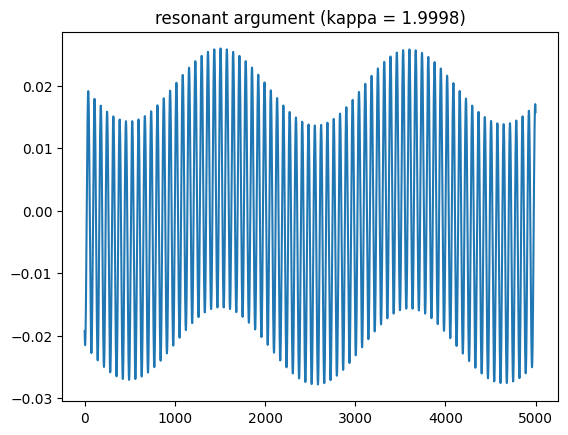

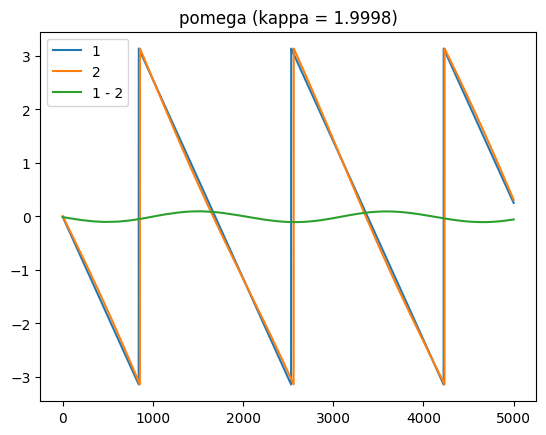

[-1.5 -1.5  0.   0. ] 4.4570641144987167e-29
[-1.5375 -1.5     0.      0.    ] 1.1537090738857298e-29
[-1.5375e+00 -1.5000e+00  0.0000e+00  2.5000e-04] 1.916374761679158e-15
[-8.00000000e-01 -1.76320741e+00  2.03492477e-03  2.79785734e-04] 3.328981566464208e-19
[-8.00000000e-01 -1.76730136e+00  2.00849259e-03  2.90944418e-04] 1.7803719865339006e-17
[-8.00000000e-01 -1.76712325e+00 -7.60568158e-04  5.49051500e-04] 1.2787777614990673e-15
[-8.00000000e-01 -1.76708923e+00 -7.01059750e-04  5.46413558e-04] 1.4132550970382002e-13
[-8.00000000e-01 -1.76750919e+00 -6.39460453e-04  5.73018332e-04] 1.4065118496021545e-11
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04] 1.2681751177486516e-09
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol':

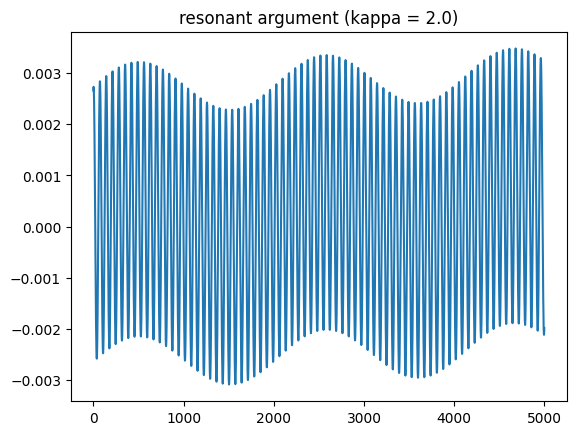

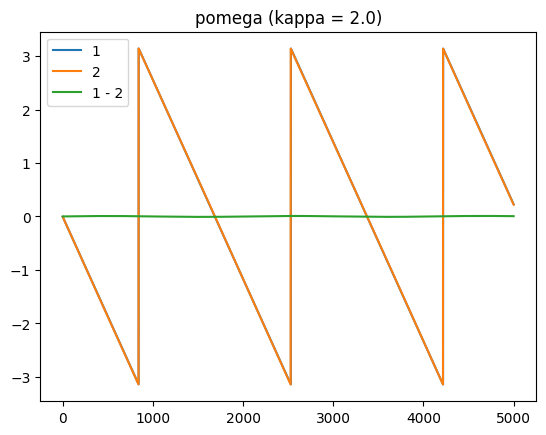

[-1.22364465e+00 -1.39630006e+00  6.28195078e-04  6.62235846e-04] 3.946290565345677e-07
[-1.22364465e+00 -1.39630006e+00  6.28195078e-04  6.95347638e-04] 3.946290565350031e-07
[-8.00000000e-01 -6.46437467e+00  3.03651627e-03  1.29062084e-03] 1.9723673936336301e-07
[-8.60236896e-01 -5.62294542e+00  3.15948172e-03  1.31640290e-03] 1.973393752003478e-07
[-9.26323160e-01 -4.90357720e+00  3.29541887e-03  1.33597693e-03] 1.973089826566766e-07
[-9.78289488e-01 -4.39243877e+00  3.55844877e-03  1.36173972e-03] 1.967155920734766e-07
[-9.91031175e-01 -3.77304457e+00  3.60459015e-03  1.51282231e-03] 1.9019325336783632e-07
[-1.00407560e+00 -4.43872870e+00  7.02503765e-04  4.56741790e-04] 1.2427992252817622e-07
[-9.68170578e-01 -2.72115283e+00  4.65730229e-04  8.94518839e-04] 7.371820769059928e-08
[-9.68170578e-01 -2.72115283e+00  4.65730229e-04  8.94518839e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0002), 'inner_period': 6.283185307179586, 

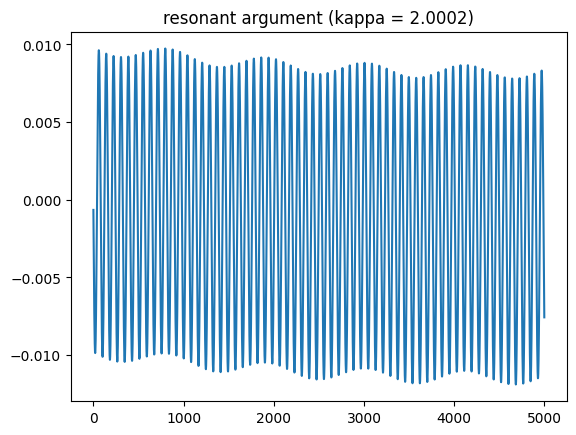

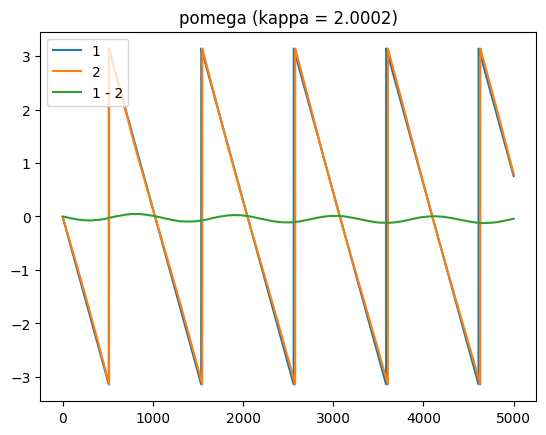

[-8.36226964e-01 -1.34261162e+00  1.20378706e-03  1.13946268e-03] 1.5785057711996358e-06
[-8.00000000e-01 -1.48736631e+00  1.25639520e-03  1.12768306e-03] 1.5784401751310135e-06
[-8.00000000e-01 -1.56173462e+00  1.25639520e-03  1.12768306e-03] 1.5782985967015864e-06
[-8.00124999e-01 -1.56272675e+00  1.25643531e-03  1.14065214e-03] 1.578338337391822e-06
[-8.00112275e-01 -4.76560067e+00 -2.86936574e-04  1.51297044e-03] 7.892200457185689e-07
[-8.80576891e-01 -4.00290460e+00 -2.97973062e-04  1.58879355e-03] 7.886422695319226e-07
[-9.84654738e-01 -3.87461397e+00 -2.75032240e-04  1.91363372e-03] 7.756970031661373e-07
[-1.00338400e+00 -4.57005183e+00 -4.01208423e-04 -9.60818409e-04] 6.350825992313975e-07
[-9.97154603e-01 -3.59107977e+00 -5.81994508e-04 -5.91380959e-04] 1.0896924995688205e-10
[-9.97154603e-01 -3.59107977e+00 -5.81994508e-04 -5.91380959e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0004), 'inner_period': 6.283185307179586,

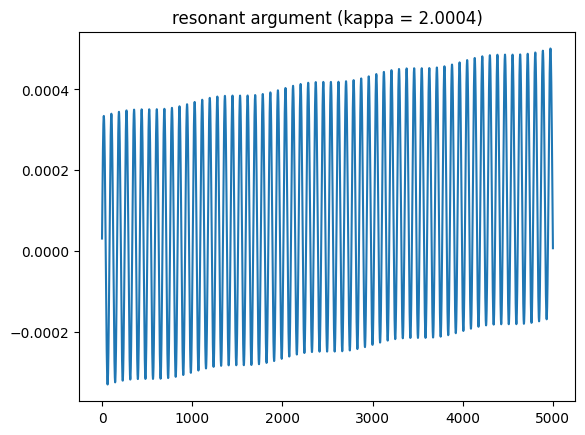

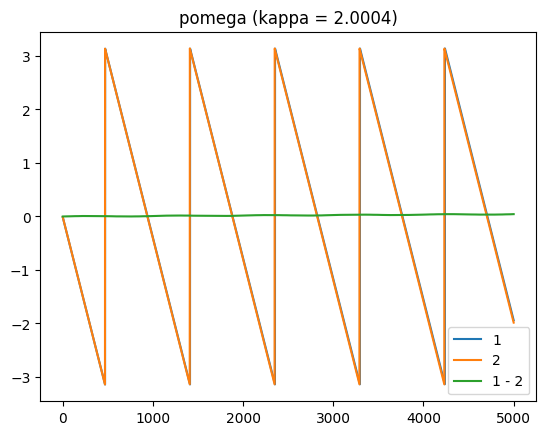

[-8.00000000e-01 -8.94133572e+00  1.73178283e-02  7.74234423e-03] 1.759265595836362e-06
[-8.50965488e-01 -8.07741705e+00  1.81181638e-02  7.86047021e-03] 1.773918712971286e-06
[-0.8960831  -7.23634855  0.01922504  0.00804953] 1.776646098906993e-06
[-0.80096765 -5.94488188  0.02209549  0.00921504] 1.7763426404228862e-06
[-0.80263011 -4.94868172  0.01729305  0.02041206] 1.7754307617789987e-06
[-0.93701523 -4.45728912  0.01962758  0.01909864] 1.7739602627271214e-06
[-0.99577332 -4.43391824  0.01956425  0.01901609] 1.7522937333673457e-06
[-1.00245333 -4.57179568  0.02117723  0.02032922] 1.5409954512356383e-06
[-1.00083295 -4.41874571  0.02161262  0.0213226 ] 1.853536358621689e-07
[-1.00083295 -4.41874571  0.02161262  0.0213226 ]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0006), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


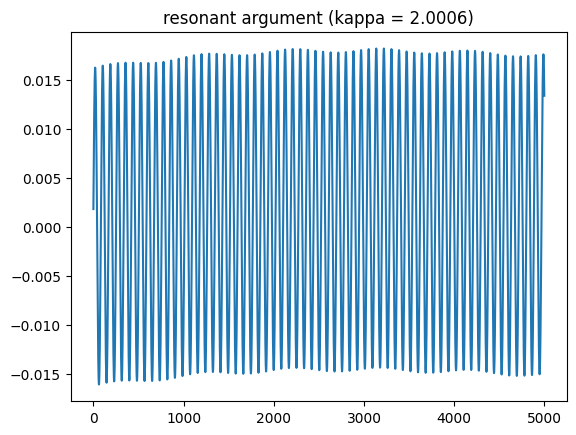

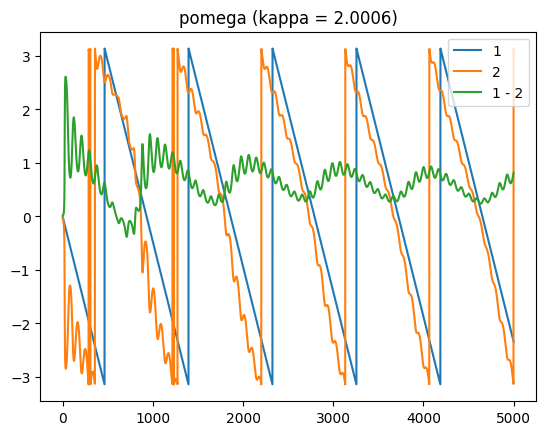

[-9.57636428e-01 -9.76429443e+00 -1.05923496e-02  8.26925126e-03] 2.987020503264908e-06
[-0.92630048 -8.52565177 -0.01189476  0.00934825] 3.162667608767841e-06
[-0.88469872 -7.31816991 -0.01273314  0.0099032 ] 3.1639595823529805e-06
[-0.80040463 -6.07187851 -0.0147064   0.01036034] 3.160628062486365e-06
[-0.8        -5.07136428 -0.01614836  0.01133637] 3.1615362077562546e-06
[-0.91984645 -4.48124377  0.06838901  0.07374711] 3.1539329321798916e-06
[-0.99820446 -4.77291394  0.07058727  0.06984946] 3.1242289694323155e-06
[-1.00114382 -4.45400944  0.07347174  0.07242197] 2.8423176690921008e-06
[-1.00051653 -4.76878367  0.0697654   0.06916831] 7.649363962426948e-07
[-1.00051653 -4.76878367  0.0697654   0.06916831]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0008), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


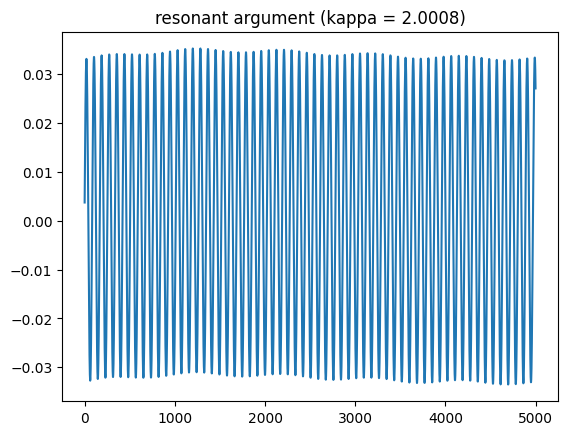

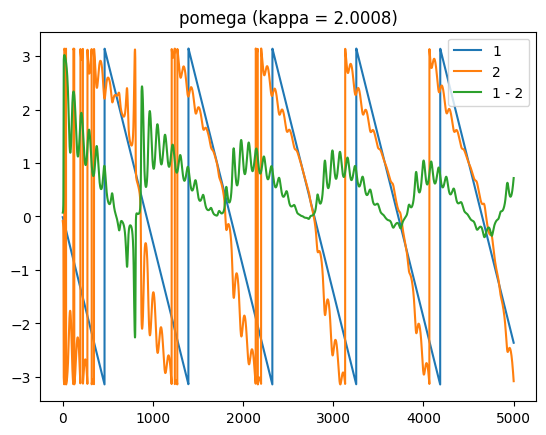

[-9.62966889e-01 -7.81074421e+00  3.03142587e-03  5.63351959e-03] 9.189697831520848e-06
[-8.55313471e-01 -8.31770488e+00  3.20703375e-03  5.77282051e-03] 4.8680710206182785e-06
[-8.96167740e-01 -7.46884975e+00  3.29611741e-03  6.08702355e-03] 4.922349473817048e-06
[-9.23697880e-01 -6.59852405e+00  3.57988391e-03  6.14872666e-03] 4.929583317225831e-06
[-9.54917202e-01 -5.82949491e+00  3.69136166e-03  6.43582690e-03] 4.931135527264589e-06
[-9.24036318e-01 -4.60495912e+00  4.01233126e-03  6.48918455e-03] 4.928060974465041e-06
[-0.98110593 -4.20949509  0.00536525  0.00444236] 4.894704416292038e-06
[-0.99750439 -4.06237209  0.00559917  0.00448503] 4.547345880024802e-06
[-0.99979176 -4.816643    0.01108076  0.01015111] 1.7453296923596893e-06
[-0.99979176 -4.816643    0.01108076  0.01015111]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.001), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_ste

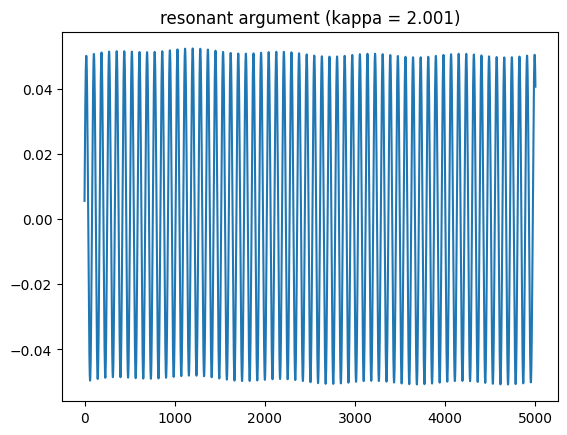

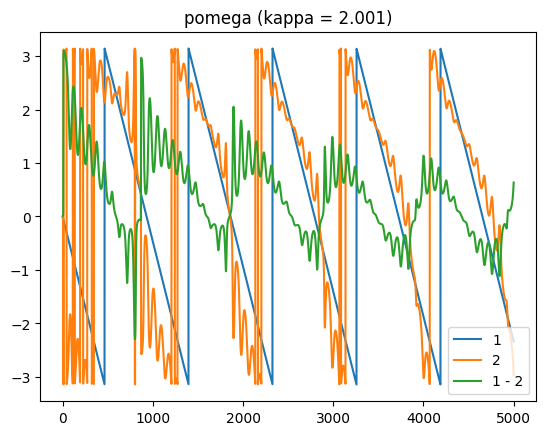

In [6]:
# Mass Continuation then Kappa

mass_cands = 10 ** np.arange(-12., -3., 1.)
kappa_cands = np.linspace(1.9990, 2.0010, 11)

bounds = [(-10, -0.8), (-10, -0.8), (-np.pi, np.pi), (-np.pi, np.pi)]

for j, kappa in enumerate(kappa_cands):
    init_theta = [-1.5, -1.5, 0, 0]
    
    for i, m in enumerate(mass_cands):
        m_configs = default_configs.copy()
        m_configs['planet_mass'] = [m, m]
        m_configs['kappa'] = kappa
    
        res = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,))
        init_theta = res.x
        print(res.x, res.fun)
    
    print(res.x)

    marks = np.arange(0, 5001, 1)

    sim = init_simulation(res.x, m_configs)
    _, target_time, _, _ = integrate_one_cycle(sim, m_configs)
    print(m_configs)
    
    angle_hist = np.zeros(len(marks))
    pomega_1_hist = np.zeros(len(marks))
    pomega_2_hist = np.zeros(len(marks))
    
    for i, _ in enumerate(marks):
        sim.integrate(sim.t + target_time)
        sim.t = 0
        sim.move_to_hel()
        
        angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega
    
        pomega_1_hist[i] = sim.particles[1].pomega
        pomega_2_hist[i] = sim.particles[2].pomega
    
        # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

    plt.plot(wrap_angles(angle_hist))
    plt.title(f'resonant argument (kappa = {m_configs['kappa']})')
    plt.show()
    plt.plot(wrap_angles(pomega_1_hist), label='1')
    plt.plot(wrap_angles(pomega_2_hist), label='2')
    plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
    plt.legend()
    plt.title(f'pomega (kappa = {m_configs['kappa']})')
    plt.show()
        